<a href="https://colab.research.google.com/github/M-McKegney/UL_ET5003_Etivity1_2021/blob/main/ET5003_Etivity1_MichaelMcKegney_20149743.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Student Name: Michael McKegney**

# **Student ID: 20149743**

<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-1

In [292]:
#@title Current Date
Today = '2021-09-19' #@param {type:"date"}


In [293]:
#@markdown ---
#@markdown ### Enter your details here:
Student_ID = "20149743" #@param {type:"string"}
Student_full_name = "Michael McKegney" #@param {type:"string"}
#@markdown ---

In [294]:
#@title Notebook information
Notebook_type = "Etivity" #@param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = "Draft" #@param ["Draft", "Final"] {type:"raw"}
Submission = False #@param {type:"boolean"}

# **Introduction:**

The purpose of Etivity 1 is to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

The classifiers are used on the MNIST dataset and their performance is compared.

The provided task information is stated below.

## Task

You have to extend the code to manage any arbitrary number of classes, in other words you have to implement a general-recipe multinomial logistic classifier and Bayesian multinomial logistic classifier.

You must then select  3 digits at random and perform  the following task. 

1. Your goal is to use Bayesian multinomial logistic regression (as in the road-sign notebook) to solve this classification problem. 

2. You can downsize the training dataset (e.g., 40% training and 60%testing) if the computation of the posterior takes too much time in your computer.

3. Use the posterior uncertainty to detect the instances (digits) in the test set that are hard to classify and remove them from the test-set.

4. Then you need to compute again the accuracy of the general-recipe logistic regression on the remaining (non-difficult) instances and comment on the result.

5. In practice, the task is to use uncertainty estimation to detect the difficult instances in the test-set. This is equivalent to refuse to classify all high-uncertainty instances or, in other words, when we are uncertain we say "I don't know" and we do not return any class. In this way, you will learn how uncertainty can be used to make safer decisions, by detecting the instances that are difficult to classify.


# **Dataset Information:**

The MNIST database  is a dataset of handwritten digits that has been and is extensively used in machine learning. There are $10$ classes, each image is $28\times28$ pixels and, therefore, each input is $x_i\in\mathbb{R}^{784}$. 

There is 60,000 images in the training set and 10,000 images in the test set.

The images are in grayscale and each pixel is represented by an 8-bit integer from 0 to 255. The images represent the digits '0' to '9'.

The data was sourced from Sulis but can also be found at the following website:
https://www.kaggle.com/oddrationale/mnist-in-csv 

## Libraries

In [295]:
# Suppressing Warnings:
import warnings
warnings.filterwarnings("ignore")

In [236]:
# Import libraries
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import scipy.optimize as optimize
from scipy.special import erf
import pandas as pd
import numpy as np
import seaborn as sns
from tqdm import tqdm
from skimage.io import imread, imshow
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
import arviz as az
from scipy.io import loadmat
import pymc3 as pm
import random
from IPython.display import HTML
import pickle
import theano as tt
import cv2
from sklearn.utils import shuffle
from skimage.color import rgb2gray

In [237]:
# Setting a seed:
np.random.seed(123)

## Read in the dataset

Be careful with the 'Path' location shown below i.e. make sure it is pointing to where you store the data for Etivity 1!

The following code is being used to determine if a Jupyter Notebook or Google Colab environment is being used to load the MNIST dataset.

The majority of the development work for this Etivity was done in Google Colab due to the runtime differences.

In [238]:
# Checking if you are using Google Colab.

RunningInCOLAB = 'google.colab' in str(get_ipython())

if RunningInCOLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    
    # paste the path here, keep quotation marks and the trailing slash
    Path = '/content/drive/MyDrive/UL_Colab_Files/ET5003/Etivity1/'
    
else:
    
    Path = './Etivity1/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [239]:

# MNIST Data
train_data = Path + 'mnist_train.csv'
test_data = Path + 'mnist_test.csv'


# train data
df_train = pd.read_csv(train_data)
X_train = df_train.drop("label",axis=1).values
y_train = df_train.label.values
#print(X_train.shape)

# test data
df_test = pd.read_csv(test_data)
X_test = df_test.drop("label",axis=1).values
y_test = df_test.label.values
#print(X_test.shape)

# Print out dataset information.
print('\n')
print('X_train.shape: ', X_train.shape)
print('y_train.shape: ', y_train.shape)
print('\n')
print('X_test.shape: ', X_test.shape)
print('y_test.shape: ', y_test.shape)



X_train.shape:  (60000, 784)
y_train.shape:  (60000,)


X_test.shape:  (10000, 784)
y_test.shape:  (10000,)


As all pixel values range from 0 to 255, by dividing by 255 each value gets 'normalised' to the range 0 to 1.

In [240]:
# Normalizing the Inputs:
X_train = X_train/255
X_test = X_test/255

# Printing the new input range of values:
minv = np.min(X_train)
maxv = np.max(X_train)
print(minv,maxv)

0.0 1.0


### Description of Data:

In [241]:
# Number of examples
n_train =  len(X_train)
n_test =  len(X_test)

# Image shape.
image_shape = X_train.shape[1]

# unique classes/labels in the training dataset.
alltotal = set(y_train)
n_classes = len(alltotal)

print("Number of Training examples =", n_train)
print("Number of Test examples =", n_test)
print("Image input shape =", image_shape)
print("Number of classes =", n_classes)

Number of Training examples = 60000
Number of Test examples = 10000
Image input shape = 784
Number of classes = 10


### Class Distribution:

Plot a histogram which displays how many of each digit '0' to '9' is present in the training data.

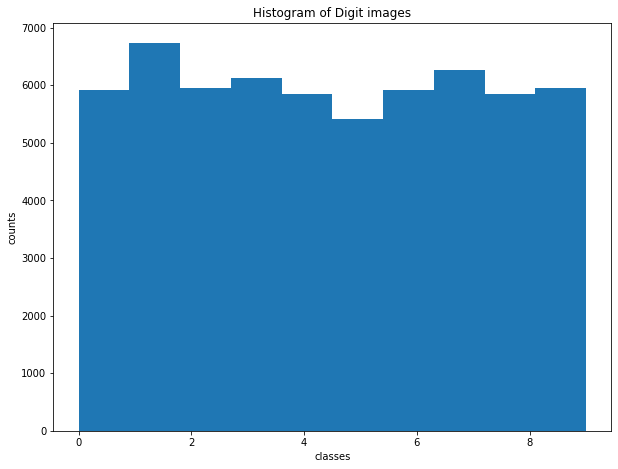

In [242]:
fig, ax = plt.subplots(figsize=(10,7.5))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

# **Method:**

## Downsampling

### Randomly selecting 3 of the 10 Digit Classes

In [243]:

# Convert the set 'alltotal' to a list.
list_of_classes = list(alltotal)


In [244]:
# We select the number of Classes we want:
n_classes = 3                                                               # Being set to 3 for now.

# Empty list to append the random digit classes we select:
classes = []                                                                

#classes = random.sample(population=list_of_classes, k=n_classes)           

# We select 3 digits at random and make sure they are unique:
while len(classes) < n_classes:                                             
    
    # Randomly drawing a digit from 0-9:
    num2choose = np.random.randint(0,10)

    label = num2choose                                                      

    # Append the digit if it's not already in our list of classes:
    if label not in classes: 
        classes.append(num2choose)
        
        
# Sorting the Classes smallest to largest    
classes.sort()                                                              
# print classes selected
classes

[1, 2, 6]

Choosing to retain 1500 instances of each digit.

In [245]:
# The number of instances we'll keep for each of our 3 digits:
inst_class = 1500                                                           # Random choice for now

inputs = []                                                                 # Defining as a blank list.
labels = []                                                                 # Defining as a blank list.

# Loop to randomly sample the instances for each digit:
for r in classes:
    imgs = X_train[np.where(y_train==r)[0],:]
    inputs.append(imgs[np.random.permutation(imgs.shape[0]),:][0:inst_class,:])
    labels.append(np.ones(inst_class)*r)
    
# Shaping inputs and labels in the right format    
X_train = np.vstack(inputs).astype(np.float64)
y_train = np.hstack(labels)

In [246]:
# DEBUG
#X_train.shape
#X_train
#y_train.shape
#y_train

#print(type(X_train))

### New Classes Distribution

Plot a histogram which displays how many of each randomly selected digit there is present.

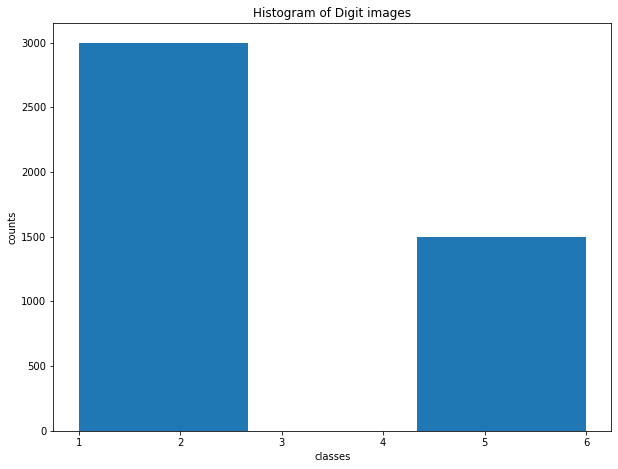

In [247]:
fig, ax = plt.subplots(figsize=(10,7.5))
ind = np.arange(n_classes)

n, bins, patches = ax.hist(y_train, n_classes)
ax.set_xlabel('classes')
ax.set_ylabel('counts')
ax.set_title(r'Histogram of Digit images')
plt.show()

In [248]:
# plot digits
def plot_digits(instances, images_per_row=5, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image,  cmap='gist_yarg', **options)
    plt.axis("off")

Show a few instances from each digit.

In [249]:
#Debug

#X_train.shape
#y_train.shape

Text(0.5, 1.0, 'Original')

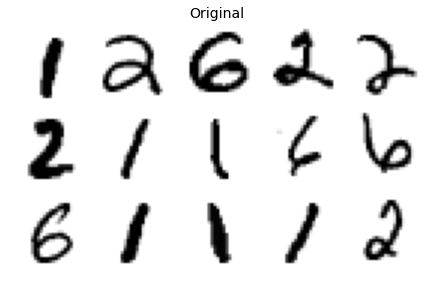

In [250]:
# num_inst_to_plot = 10

# loop_counter = 0

# for each_class in classes:
#   plt.figure(figsize=(8,8))
#   plot_digits(X_train[(loop_counter*inst_class):((loop_counter*inst_class)+num_inst_to_plot)],10)
#   plt.show
#   loop_counter += 1


# Show a few instances from each Digit:
plt.figure(figsize=(7.5,7.5))

# Selecting a few label indices from each of the 3 classes to show:
label_indices = np.random.choice(len(X_train),15,replace=False)

# Plotting 'original' image
plot_digits(X_train[label_indices,:],images_per_row=5)
plt.title("Original", fontsize=14)


###  Splitting the Training data into both Training and Validation Sets:

- Although this is the Training set, we can still set aside some samples (for instance 20%) of the 1,500 instances we have for Model Validation purposes.


- With that Validation Set, we can then select the amount of Uncertainty we are happy with from our Model to use out of sample on other unseen data.


- We can then test out how well our decision performs on the Test Set that we put aside earlier.

In [251]:
### Split tha dataset in training and validation sets
# choose the fraction of your validation data from the training set
w = 0.20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=w, random_state=0)
 
# Shuffling the training instaces around to randomize the order of inputs to the model:
X_train, y_train = shuffle(X_train, y_train)

In [252]:
# print shape of your validation and training set


print('X_train: ', X_train.shape, '\nX_val: ', X_val.shape, '\ny_train: ', y_train.shape, '\ny_val: ', y_val.shape)


X_train:  (3600, 784) 
X_val:  (900, 784) 
y_train:  (3600,) 
y_val:  (900,)


### Encoding the Class labels for the Probabilistic ML Model:

This is an example:

- **[1,0,0]** for first digit
- **[0,1,0]** for second digit
- **[0,0,1]** for third digit

### General-Recipe ML

Transforming images into vectors before running multinomial logistic regression.

In [253]:

# transform images into vectors  

# Lines of code from the lab file.
# X_trv = X_train.flatten().reshape(X_train.shape[0],X_train.shape[1]*X_train.shape[2])
# X_valv = X_val.flatten().reshape(X_val.shape[0],X_train.shape[1]*X_train.shape[2])


X_trv = X_train.flatten().reshape(X_train.shape[0],X_train.shape[1])
X_valv = X_val.flatten().reshape(X_val.shape[0],X_train.shape[1])

y_tr = y_train.copy()

print(X_trv.shape)
print(X_valv.shape)
print(y_tr.shape)
print(y_val.shape)

(3600, 784)
(900, 784)
(3600,)
(900,)


In [254]:
# model
model_log = LogisticRegression(random_state=0, max_iter=2000, C=100, solver='lbfgs', multi_class='multinomial').fit(X_trv, y_tr)      

# Classification:
y_pred_logi = model_log.predict(X_valv)                           
y_pred_logi_prob = model_log.predict_proba(X_valv)               

# Maybe taking the maximum probability 
# in any of the classes for each observation
prob_classmax = np.max(y_pred_logi_prob,axis=1)                  

# Computing the Accuracy:
accuracy_score(y_pred_logi, y_val)

0.9766666666666667

In [255]:
# Only commenting out to avoid long print out.

#np.sort(prob_classmax)

In [256]:
# Probability of general-recipe logistic regression in wrong instances.
prob_classmax[y_pred_logi!=y_val]

array([0.99744985, 0.52198065, 0.99966378, 0.86669845, 0.97683286,
       0.87065449, 0.99787179, 0.5057352 , 0.98862742, 0.90960885,
       0.99999999, 0.99474148, 0.7824442 , 0.99333234, 0.98671087,
       0.91243323, 0.88963716, 0.99922409, 1.        , 0.99998343,
       0.82583129])

In [257]:
# np.array(y_pred_logi)

### Probabilistic Multinomial Logistic Regression:

The Multinomial Logistic Regression has some parameters:

- $\alpha$, which is the intercept term:

- $\beta$, which is a vector of coefficients which give a weighting to the importance of each input feature:


In [258]:
import sklearn.preprocessing
## We use LabelBinarizer to transfor classes into counts
# neg_label=0, pos_label=1 
y_2_bin = sklearn.preprocessing.LabelBinarizer().fit_transform(y_tr.reshape(-1,1))
nf = X_trv.shape[1]
# number of classes
nc = len(classes)
# floatX = float32
floatX = tt.config.floatX

init_b = np.random.randn(nf, nc-1).astype(floatX)
init_a = np.random.randn(nc-1).astype(floatX)


with pm.Model() as multi_logistic:
    # Prior
    β = pm.Normal('beta', 0, sigma=100, shape=(nf, nc-1), testval=init_b)
    α = pm.Normal('alpha', 0, sigma=100, shape=(nc-1,), testval=init_a)
    
    # we need to consider nc-1 features because the model is not identifiable
    # the softmax turns a vector into a probability that sums up to one
    # therefore we add zeros to go back to dimension nc
    # so that softmax returns a vector of dimension nc
    β1  = tt.tensor.concatenate([np.zeros((nf,1)),β ],axis=1)
    α1  = tt.tensor.concatenate([[0],α ],)
    
    # Likelihood
    mu = pm.math.matrix_dot(X_trv,β1) + α1
    # It doesn't work if the problem is binary
    p = tt.tensor.nnet.nnet.softmax(mu)
    observed = pm.Multinomial('likelihood', p=p, n=1, observed=y_2_bin)




In [259]:
y_2_bin


array([[0, 1, 0],
       [0, 0, 1],
       [0, 0, 1],
       ...,
       [0, 0, 1],
       [1, 0, 0],
       [1, 0, 0]])

In [260]:
with multi_logistic:
    #approx = pm.fit(300000, method='advi') # takes longer
    approx = pm.fit(3000, method='advi')

Finished [100%]: Average Loss = 10,260


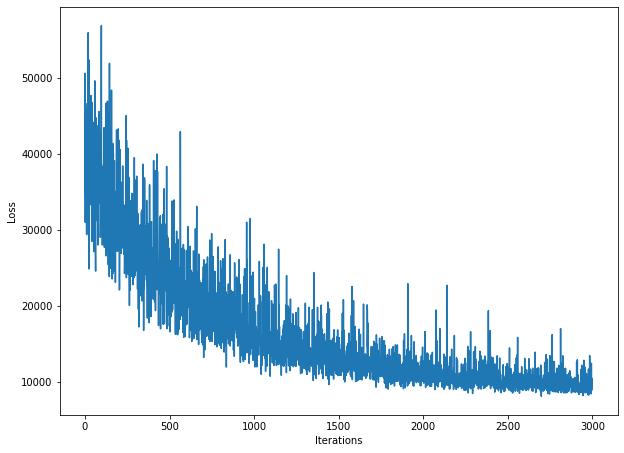

In [261]:
plt.figure(figsize=(10,7.5))
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.plot(approx.hist)
plt.show()

In [262]:
dd = 300
posterior = approx.sample(draws=dd)

test image #10
posterior sample #100
true class= 2.0
classes: [1, 2, 6]
estimated prob= [0.23952808 0.76046575 0.00000616]


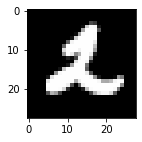

In [263]:
## The softmax function transforms each element of a collection by computing the exponential
#  of each element divided by the sum of the exponentials of all the elements.
from scipy.special import softmax

#select an image in the test set
i = 10 
#i = random.randint(0, dd)

#select a sample in the posterior
s = 100 
#s = random.randint(0, dd)


beta  = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
alpha = np.hstack([[0],  posterior['alpha'][s,:] ])

# image = X_valv[i,:].reshape(32,32)
image = X_valv[i,:].reshape(28,28)

plt.figure(figsize=(2,2))
plt.imshow(image,cmap="Greys_r")
np.set_printoptions(suppress=True)

print("test image #" + str(i))
print("posterior sample #" + str(s))
print("true class=", y_val[i])
print("classes: " + str(classes))
print("estimated prob=",softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

In [264]:
# Bayesian prediction
# return the class that has the highest posterior probability
y_pred_Bayesian=[]

for i in range(X_valv.shape[0]):
    val=np.zeros((1,len(classes)))
    
    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])     
        val = val + softmax((np.array([X_valv[i,:].dot(beta) + alpha])))
    
    mean_probability = val/posterior['beta'].shape[0]
    y_pred_Bayesian.append( np.argmax(mean_probability))


In [265]:
print(y_pred_Bayesian)

[0, 1, 1, 2, 1, 1, 0, 0, 0, 0, 1, 2, 1, 0, 2, 1, 0, 2, 1, 1, 2, 1, 1, 2, 2, 1, 1, 0, 0, 0, 1, 2, 0, 0, 0, 0, 2, 0, 0, 0, 2, 0, 0, 2, 1, 0, 2, 1, 1, 1, 2, 1, 2, 2, 0, 2, 0, 2, 0, 2, 1, 2, 2, 0, 0, 2, 0, 1, 0, 2, 0, 2, 0, 2, 1, 1, 1, 1, 0, 0, 0, 2, 2, 1, 0, 2, 0, 0, 1, 2, 2, 0, 1, 2, 2, 0, 1, 0, 1, 2, 1, 1, 0, 1, 2, 2, 2, 0, 1, 1, 1, 2, 2, 2, 1, 0, 1, 2, 1, 2, 0, 1, 1, 1, 1, 2, 0, 2, 1, 2, 2, 1, 1, 0, 2, 2, 0, 2, 0, 2, 2, 2, 1, 1, 0, 0, 1, 2, 2, 2, 2, 1, 0, 2, 0, 2, 1, 1, 0, 2, 1, 0, 0, 0, 2, 2, 0, 2, 0, 1, 0, 1, 2, 1, 1, 1, 1, 2, 0, 0, 0, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 0, 1, 0, 1, 0, 0, 1, 0, 2, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 2, 0, 2, 1, 0, 1, 2, 1, 1, 0, 1, 0, 1, 2, 0, 1, 0, 1, 1, 1, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 0, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 0, 1, 1, 1, 2, 0, 1, 2, 2, 0, 1, 1, 0, 2, 0, 0, 2, 0, 0, 2, 0, 1, 1, 0, 1, 1, 1, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 1, 0, 0, 1, 2, 1, 1, 2, 1, 0, 0, 0, 1, 2, 0, 2, 2, 1, 0, 2, 0, 2, 2, 0, 0, 0, 1, 0, 0, 0, 0, 2, 0, 0, 0, 

In [266]:
# recall the classes we are using
print(classes)

[1, 2, 6]


In [267]:
# prediction array (using classes)
nn = 10 # just an example
np.array(classes)[y_pred_Bayesian[0:nn]]

array([1, 2, 2, 6, 2, 2, 1, 1, 1, 1])

In [268]:
# using validation: y_val
print("Accuracy=", accuracy_score(np.array(classes)[y_pred_Bayesian], y_val))

Accuracy= 0.9277777777777778


## Selecting different instances

In [269]:
y_predB=[]

for i in range(X_valv.shape[0]):
    #print(i)
    val=[]

    for s in range(posterior['beta'].shape[0]):
        beta = np.hstack([np.zeros((nf,1)),  posterior['beta'][s,:] ])
        alpha = np.hstack([[0],  posterior['alpha'][s,:] ])
        val.append(softmax((np.array([X_valv[i,:].dot(beta) + alpha])))[0,:])

    #mean probability
    valmean = np.mean(val,axis=0)
    #class with maximum mean probability
    classmax = np.argmax(valmean)
    #ranks
    ranks = np.array(val.copy())
    ranks   = ranks  *0 #init
    colmax = np.argmax(np.array(val),axis=1)
    ranks[np.arange(0,len(colmax)),colmax]=1
     
    y_predB.append( [classmax, valmean[classmax], np.std(ranks,axis=0)[classmax]])

    
y_predB= np.array(y_predB)

In [270]:
# prediction array
mm = 10
y_predB[0:mm,:]

array([[0.        , 0.92120183, 0.19595918],
       [1.        , 0.96407245, 0.17058722],
       [1.        , 0.99996486, 0.        ],
       [2.        , 0.96270671, 0.17950549],
       [1.        , 0.92041491, 0.24944383],
       [1.        , 0.78143892, 0.4142463 ],
       [0.        , 0.80436539, 0.35041246],
       [0.        , 0.8715607 , 0.32102267],
       [0.        , 0.97911826, 0.08137704],
       [0.        , 0.94951273, 0.19595918]])

In [271]:
#sorting in descending order
difficult = np.argsort(-y_predB[:,2])
y_predB[difficult[0:mm],:]

array([[2.        , 0.49951436, 0.5       ],
       [2.        , 0.49836739, 0.49998889],
       [1.        , 0.51481376, 0.49998889],
       [2.        , 0.48241776, 0.49998889],
       [1.        , 0.50296431, 0.49995555],
       [2.        , 0.51543743, 0.49989999],
       [2.        , 0.47315959, 0.49989999],
       [0.        , 0.49940968, 0.49989999],
       [2.        , 0.47776243, 0.49982219],
       [1.        , 0.52368335, 0.49972215]])

To try and differentiate 'easy' and 'difficult' images based off the results of the Bayesian approach, the existing standard deviation information will be used to define a threshold.

The images were classified as 'difficult' based on decreasing values of standard deviation. A threshold value of 0.4 was arbitrarily chosen as it resulted in a mean probability of 0.75 or over.

The array index where the first instance of an image having standard deviation of 0.4 or less was found as follows.

In [272]:
# Initialisations.
row_list = []
row_counter = 0

threshold = 0.4    # std dev.

# Expecting 3 classes.
for each_class in y_predB[difficult[:],0]:

  if(each_class==0):
    if(y_predB[difficult[row_counter],2])<threshold:
      row_list.append(row_counter)
  elif(each_class==1):
    if(y_predB[difficult[row_counter],2])<threshold:
      row_list.append(row_counter)
  elif(each_class==2):
    if(y_predB[difficult[row_counter],2])<threshold:
      row_list.append(row_counter)

  row_counter += 1

first_index_below_threshold = min(row_list)
difficult[first_index_below_threshold]

882

In [273]:
#probability of general-recipe logistic regression in wrong instances
prob_classmax[y_pred_logi != y_val]

array([0.99744985, 0.52198065, 0.99966378, 0.86669845, 0.97683286,
       0.87065449, 0.99787179, 0.5057352 , 0.98862742, 0.90960885,
       0.99999999, 0.99474148, 0.7824442 , 0.99333234, 0.98671087,
       0.91243323, 0.88963716, 0.99922409, 1.        , 0.99998343,
       0.82583129])

In [274]:
y_predB[y_pred_logi != y_val,:]

array([[1.        , 0.78143892, 0.4142463 ],
       [2.        , 0.6419542 , 0.47590849],
       [1.        , 0.55545264, 0.49408726],
       [2.        , 0.82451948, 0.36660606],
       [2.        , 0.47315959, 0.49989999],
       [1.        , 0.74906881, 0.42083251],
       [0.        , 0.60338954, 0.48455019],
       [1.        , 0.93709911, 0.21794495],
       [1.        , 0.60063906, 0.48989795],
       [2.        , 0.69718928, 0.45061686],
       [1.        , 0.91045373, 0.2763854 ],
       [2.        , 0.60332649, 0.4861984 ],
       [2.        , 0.36670943, 0.4861984 ],
       [2.        , 0.99766015, 0.05763872],
       [1.        , 0.94477224, 0.20360637],
       [0.        , 0.79619469, 0.38418745],
       [2.        , 0.60005172, 0.48920571],
       [2.        , 0.66313698, 0.46517619],
       [2.        , 0.99970805, 0.        ],
       [2.        , 0.98894487, 0.08137704],
       [0.        , 0.62055715, 0.48368952]])

In [275]:
## Difficult & easy instances

easy = np.argsort(y_predB[:,2])
print("Accuracy in easy instances =", accuracy_score(y_pred_logi[easy[0:100]], y_val[easy[0:100]]))

difficult = np.argsort(-y_predB[:,2])
print("Accuracy in difficult instances =", accuracy_score(y_pred_logi[difficult[0:100]], y_val[difficult[0:100]]))

Accuracy in easy instances = 0.99
Accuracy in difficult instances = 0.92


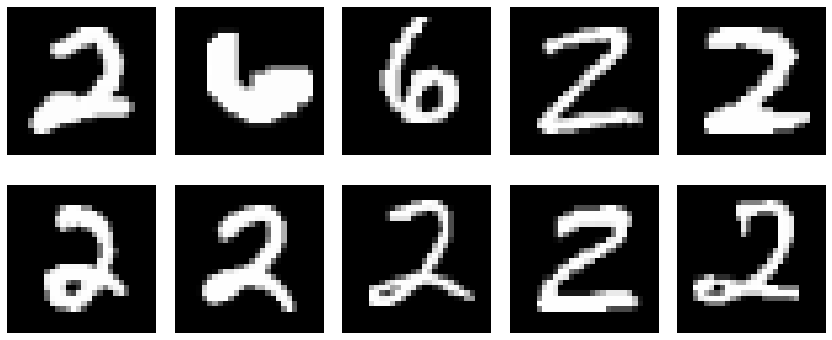

In [276]:
# show 10 random 'easy' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()

for i in range(10):
    index = easy[i]
    
    #image = X_valv[index,:].reshape(32,32)
    image = X_valv[index,:].reshape(28,28)
    
    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

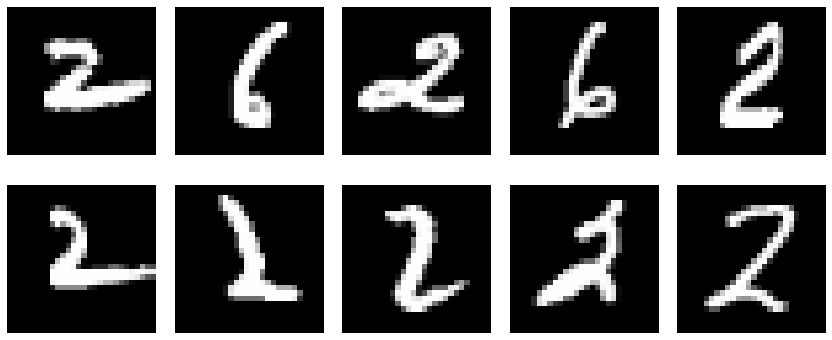

In [277]:

# show 10 random 'difficult' images
fig, axs = plt.subplots(2,5, figsize=(15, 6))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
for i in range(10):
    index = difficult[i]
    
    #image = X_valv[index,:].reshape(32,32)
    image = X_valv[index,:].reshape(28,28)

    axs[i].axis('off')
    axs[i].imshow(image,cmap="Greys_r")
    

The test set that was set aside at the very start of the notebook was checked with the general recipe logistic regression model.

In [278]:
# DEBUG
# X_test.shape
# y_test.shape
# y_pred_logi_test.shape

In [279]:
y_pred_logi_test = model_log.predict(X_test)

accuracy_score(y_pred_logi_test, y_test)

0.3057

The accuracy of the general recipe multinomial logistic regression model on the validation set was then also re-tried with the images that were considered 'difficult' being removed i.e. only using the images that were not deemed 'difficult'.

In [280]:
y_pred_logi2 = model_log.predict(X_valv[difficult[(first_index_below_threshold):]])
y_val2 = y_val[difficult[(first_index_below_threshold):]]

accuracy_score(y_pred_logi2, y_val2)

0.9885550786838341

# **Summary:**

The Google Colab environment was used to work with Etivity 1 because when I initially tried using Jupyter Notebooks, the runtime was excessively long and it was difficult to make progress.

There is however code in place to detect whether Google Colab or Jupyter Notebooks is in use and that influences where the 'Path' directory is pointed to.

The Lab1 notebook was referenced when initially attempting this Etivity and I have stuck very close to the approach displayed there. 

### <b>Approach and observations:</b>

There can be run-to-run variation of results so the figures quoted below were all recorded for a single run for the purposes of providing an example to discuss.

*   <b>1500 instances</b> were used from each class for each of the 3 digits.
*   I stuck with the <b>accuracy metric</b> used in the lab example notebook.    
    * If I had more time, it may be worth investigating other classification metrics such as precision, recall, F1-score, ROC plots, PR curves, etc. to see how they vary. ROC, PR & PRG curves may be more appropriate for probabilistic models (Lukány 2020).
*   The <b>general recipe LogisticRegression</b> approach achieved an accuracy of about <b>0.976</b> on the <b>validation set</b> initially.
*   The <b>probabilistic/Bayesian ML</b> approach claimed an accuracy of about <b>0.918</b> on the <b>validation set</b>.
    * The accuracy on the <b>'easy'</b> instances = <b>0.98</b> 
    * The accuracy on the <b>'difficult'</b> instances = <b>0.91</b>
*   When the <b>general recipe LogisticRegression</b> approach was tried on the <b>test set</b> that was set aside at the very start of the notebook, the accuracy was quite poor i.e. <b>0.3057</b>.
    * I didn't have time to explore this but I am assuming it may point to the general recipe logistic regression model overfitting the training data i.e. not generalising well.
*   When the <b>general recipe logistic regression model</b> was tried again on the <b>validation set</b> with <b>'difficult'</b> images removed, the accuracy improved to <b>0.9915</b>.

### <b>Theory:</b>

My understanding of the purpose of the Etivity is to demonstrate that the general recipe multinomial logistic regression approach can suffer from <b>overfitting</b> the training data and therefore not <b>generalise</b> well on new/test data.

The probabilistic/Bayesian multinomial logistic regression approach has the advantage of dealing with 'uncertainty'. The approach makes use of Bayes theorem as follows:
*   Bayes theorem enables the use of a <b>‘prior’</b> which is essentially previous knowledge/belief of an event. The prior can be an educated guess based on past experience or based on available data. A prior distribution (as opposed to a single prior probability) can be more appropriate if there is uncertainty in the prior belief (Brooks-Bartlett 2018). 
*   The <b>‘likelihood’</b> distribution relates to the probability of some data given a set of parameters (Brownlee 2019).
*   The <b>‘marginal likelihood’/‘evidence’</b> is a number which acts as a normalizing constant (Brooks-Bartlett 2018).
*   The <b>‘posterior’</b> distribution represents the probability of parameter values after the observed data has been factored in. 
*   The <b>MAP (maximum a posteriori probability)</b> estimate can be used to calculate a value for a desired parameter. In the case of Gaussian distributions, the mean is the same value as the mode.
*   When new data is made available, the existing posterior can become the new prior, a new likelihood can be calculated from the new data and then a new posterior can be calculated. This highlights the <b>iterative nature of Bayesian inference</b> i.e. beliefs can be updated when new data is available.
*   The key advantage the Bayesian approach has versus traditional logistic regression is that the problem of overfitting the model to the data is combatted by the use of priors. The prior can be viewed as a <b>regularization</b> term. The prior distribution can be “narrowed” / made less spread in contrast to the likelihood distribution – this will have the effect of making the posterior distribution closer to the prior distribution. This will allow the model to generalize better and <b>deal with uncertainty in a more effective way</b>.

# **References (Harvard UL):**


Brooks-Bartlett, J. (2018) <i>Probability concepts explained: Bayesian inference for parameter estimation</i>, towards data science, available: https://towardsdatascience.com/probability-concepts-explained-bayesian-inference-for-parameter-estimation-90e8930e5348 [accessed 19 September 2021].


Brownlee, J. (2019) <i>A Gentle Introduction to Bayes Theorem for Machine Learning</i>, Machine Learning Mastery, available: https://machinelearningmastery.com/bayes-theorem-for-machine-learning/ [accessed 19 September 2021].




Lukány, J. (2020) <i>Evaluating Probabilistic Classifier: ROC and PR(G) Curves</i>, Medium, available: https://medium.com/knowledge-engineering-seminar/evaluating-probabilistic-classifier-roc-and-pr-g-curves-6647c3379d60 [accessed 19 September 2021].